In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
import random
import shutil

2023-01-09 18:29:22.967647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 18:29:23.286698: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-09 18:29:23.358868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 18:29:23.358885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
batch_size = 32
img_height = 260
img_width = 260
path = '/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/data_cropped'

train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1328 files belonging to 4 classes.
Using 1063 files for training.


2023-01-09 18:29:24.979144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-09 18:29:24.979427: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 18:29:24.979441: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (steve-linux): /proc/driver/nvidia/version does not exist
2023-01-09 18:29:24.981627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1328 files belonging to 4 classes.
Using 265 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['broken', 'closed_seal_broken', 'closed_sealed', 'open_broken']


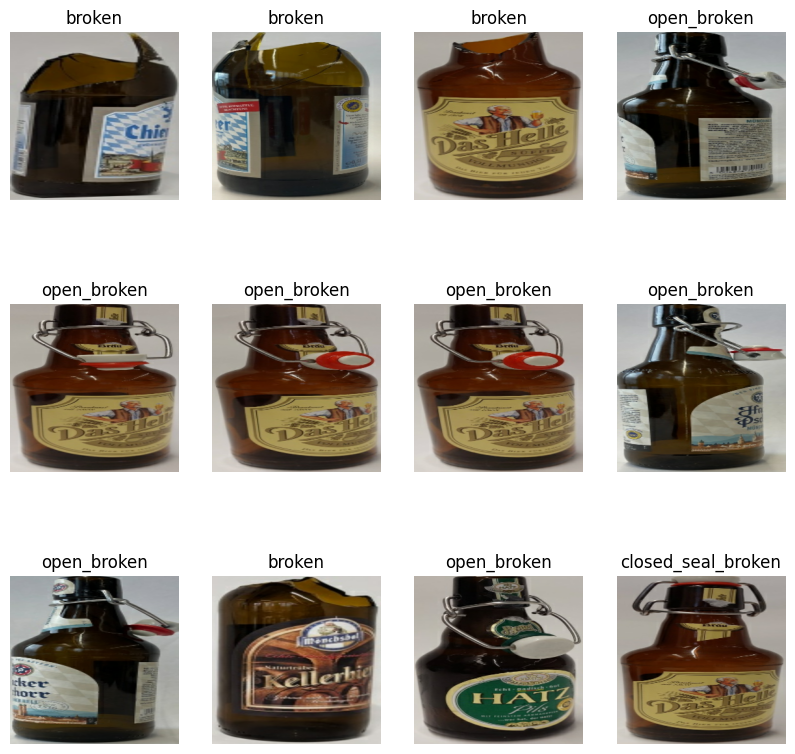

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# from tensorflow import keras
# from keras import layers
# num_classes = len(class_names)
# #example model tf
# model = keras.models.Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.3),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, activation='softmax')
#   ])
# model.summary()

In [8]:
from tensorflow import keras
from keras import layers
num_classes = len(class_names)

model = keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 260, 260, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 260, 260, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 130, 130, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 130, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 65, 64)        1

In [9]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping = EarlyStopping(
    patience=6
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=2, min_lr=0.00001)

#no early stopping to streamline the epochs plot

callbacks = [reduce_lr]






In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [11]:
epochs=22
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/22
34/34 [==============================] - 8s 215ms/step - loss: 1.0434 - accuracy: 0.6256 - val_loss: 0.6608 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - 7s 204ms/step - loss: 0.2466 - accuracy: 0.9040 - val_loss: 0.1608 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - 7s 208ms/step - loss: 0.0847 - accuracy: 0.9699 - val_loss: 0.1206 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 4/22
34/34 [==============================] - 7s 204ms/step - loss: 0.0373 - accuracy: 0.9859 - val_loss: 0.1388 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 5/22
34/34 [==============================] - 7s 206ms/step - loss: 0.0230 - accuracy: 0.9944 - val_loss: 0.1477 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 6/22
34/34 [==============================] - 7s 206ms/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.0998 - val_accuracy: 0.9623 - lr: 6.0000e-04
Epoch 7/22
34/34 [==============================] - 7s 206ms/step 

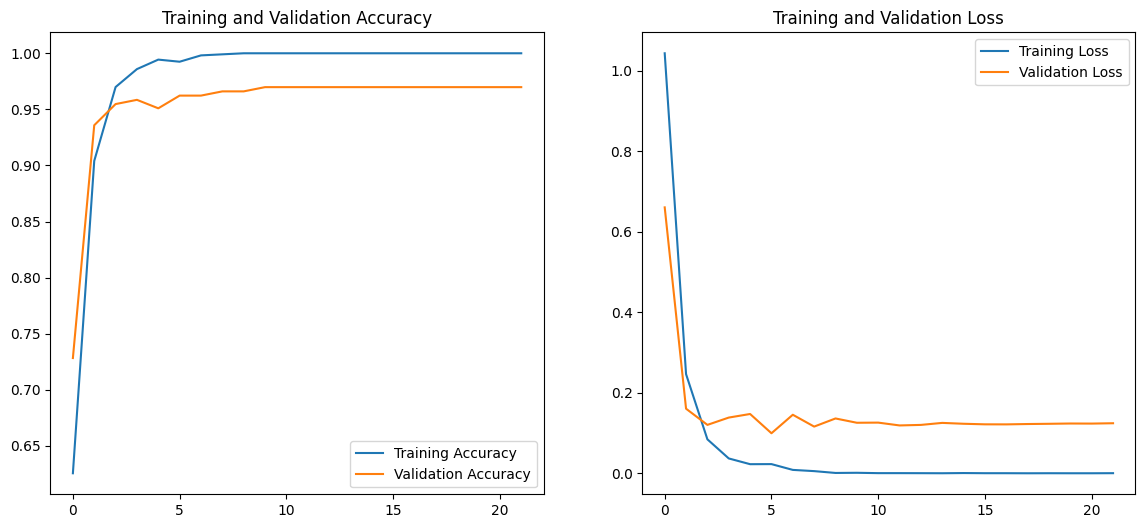

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# path_test = "/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/open.jpg"
# sunflower_path = tf.keras.utils.get_file('open', 'file://'+path_test)

In [33]:

# print(sunflower_path)

# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch
# img


Creating a test dataset

In [13]:
path_test = '/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/test_images_cropped'
test_batchsize = 4

test_ds = tf.keras.utils.image_dataset_from_directory(
  path_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=test_batchsize
)

results= model.evaluate(test_ds)
print(f"test loss: {results[0]}: test acc: {results[1]*100}%")




Found 4 files belonging to 4 classes.
1/1 [==============================] - 0s 34ms/step - loss: 1.3671 - accuracy: 0.7500
test loss: 1.3671379089355469: test acc: 75.0%


In [14]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

predictions = model.predict(test_ds)
for i in range(len(predictions)):
  score = tf.nn.softmax(predictions[i])
  print(f"\nPrediction is:{format(class_names[np.argmax(score)])} with {100 * np.max(score)}% confidence")


1/1 [==============================] - 0s 77ms/step

Prediction is:open_broken with 44.31081414222717% confidence

Prediction is:closed_seal_broken with 47.37898111343384% confidence

Prediction is:closed_seal_broken with 47.055697441101074% confidence

Prediction is:broken with 47.53669202327728% confidence


1/1 [==============================] - 0s 21ms/step


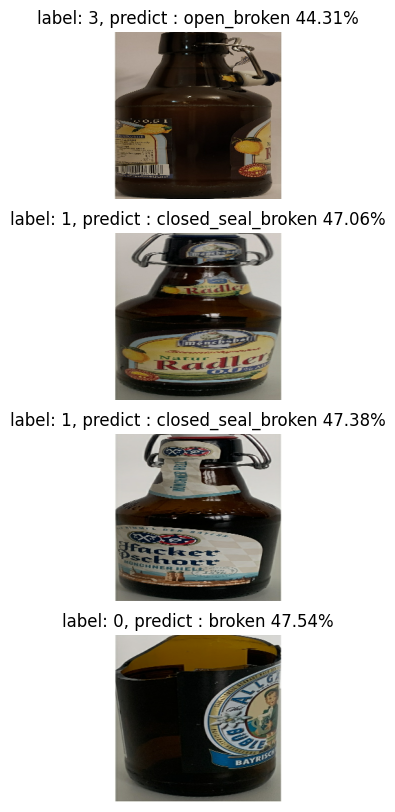

In [15]:
image ,label = next(iter(test_ds))
fig, axes = plt.subplots(4,1,figsize=(10,10))
for idx, axe in enumerate(axes.flatten()):
    axe.axis('off')
    pred = model.predict(image[idx][None,...])
    y_pred = np.argmax(pred)
    score = tf.nn.softmax(pred)
    axe.imshow(image[idx].numpy().astype("uint8"))
    axe.set_title(f'label: {y_pred}, predict : {class_names[y_pred]} {100 * np.max(score):.2f}%')